# Wavelets

In [37]:
from sklearn import preprocessing
import pandas as pd
from pathlib import Path
import pywt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from scipy.signal import butter,filtfilt
sns.set_theme()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

Helper function for visualization

In [3]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    ym = np.median(yyy)
    plt.plot(np.linspace(0, 1., num=len(yyy)), yyy-ym, **kwargs)


def reconstruction_stem(yyy, xmax, **kwargs):
    """Plot coefficient vector on x [0,1] independently of amount of values it contains."""
    ymax = yyy.max()
    plt.stem(np.linspace(0, 1., num=len(yyy)), yyy*(xmax/ymax), **kwargs)


Load data

In [4]:
fpath = Path("/home/mst/projects/flyps/myalyce/data/Unfiltered PPG, plus accelerometer/PPG_JoshuaBrewster2023-06-14T15_48_32.828(UTC-07_00).csv")
df = pd.read_csv(fpath)
df

,timestamp,localized,red,ir
0,1686782913042,2023-06-14T15:48:33.042(UTC-07:00),26462,44429
1,1686782913041,2023-06-14T15:48:33.041(UTC-07:00),26465,44426
2,1686782913040,2023-06-14T15:48:33.040(UTC-07:00),26458,44411
3,1686782913039,2023-06-14T15:48:33.039(UTC-07:00),26457,44406
4,1686782913037,2023-06-14T15:48:33.037(UTC-07:00),26457,44407
...,...,...,...,...
2555,1686782963623,2023-06-14T15:49:23.623(UTC-07:00),26601,44406
2556,1686782963643,2023-06-14T15:49:23.643(UTC-07:00),26601,44401
2557,1686782963663,2023-06-14T15:49:23.663(UTC-07:00),26601,44391
2558,1686782963683,2023-06-14T15:49:23.683(UTC-07:00),26587,44348


In [ ]:
df['']

<Axes: >

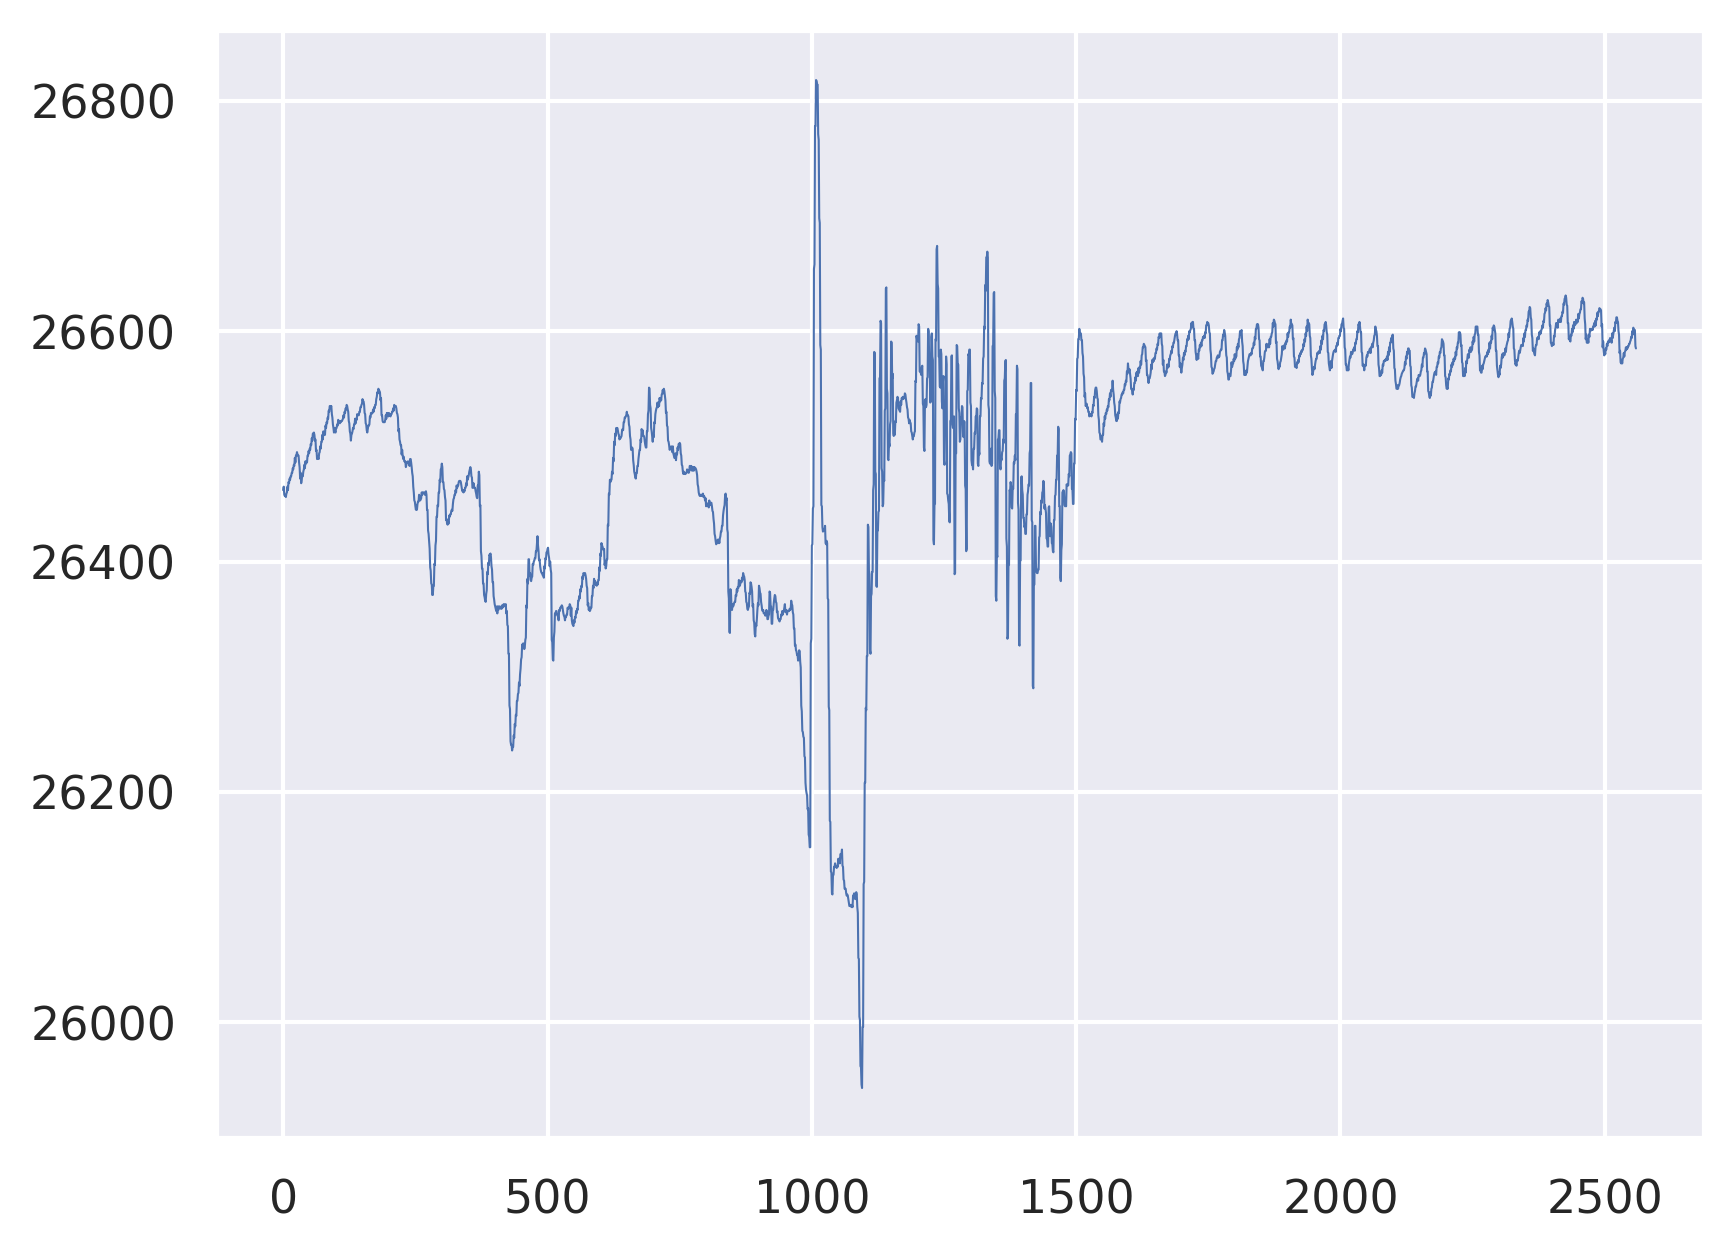

In [7]:
df['red'].plot(lw=0.5)

In [8]:
data = df['red']
w = pywt.Wavelet('sym4')
maxlev = pywt.dwt_max_level(len(data), w.dec_len)
coeffs = pywt.wavedec(data, 'sym4', level=maxlev)


In [15]:
min_max_scaler = preprocessing.MinMaxScaler().fit(df['red'].array.reshape(-1,1))

array([26462, 26465, 26458, ..., 26601, 26587, 26585])

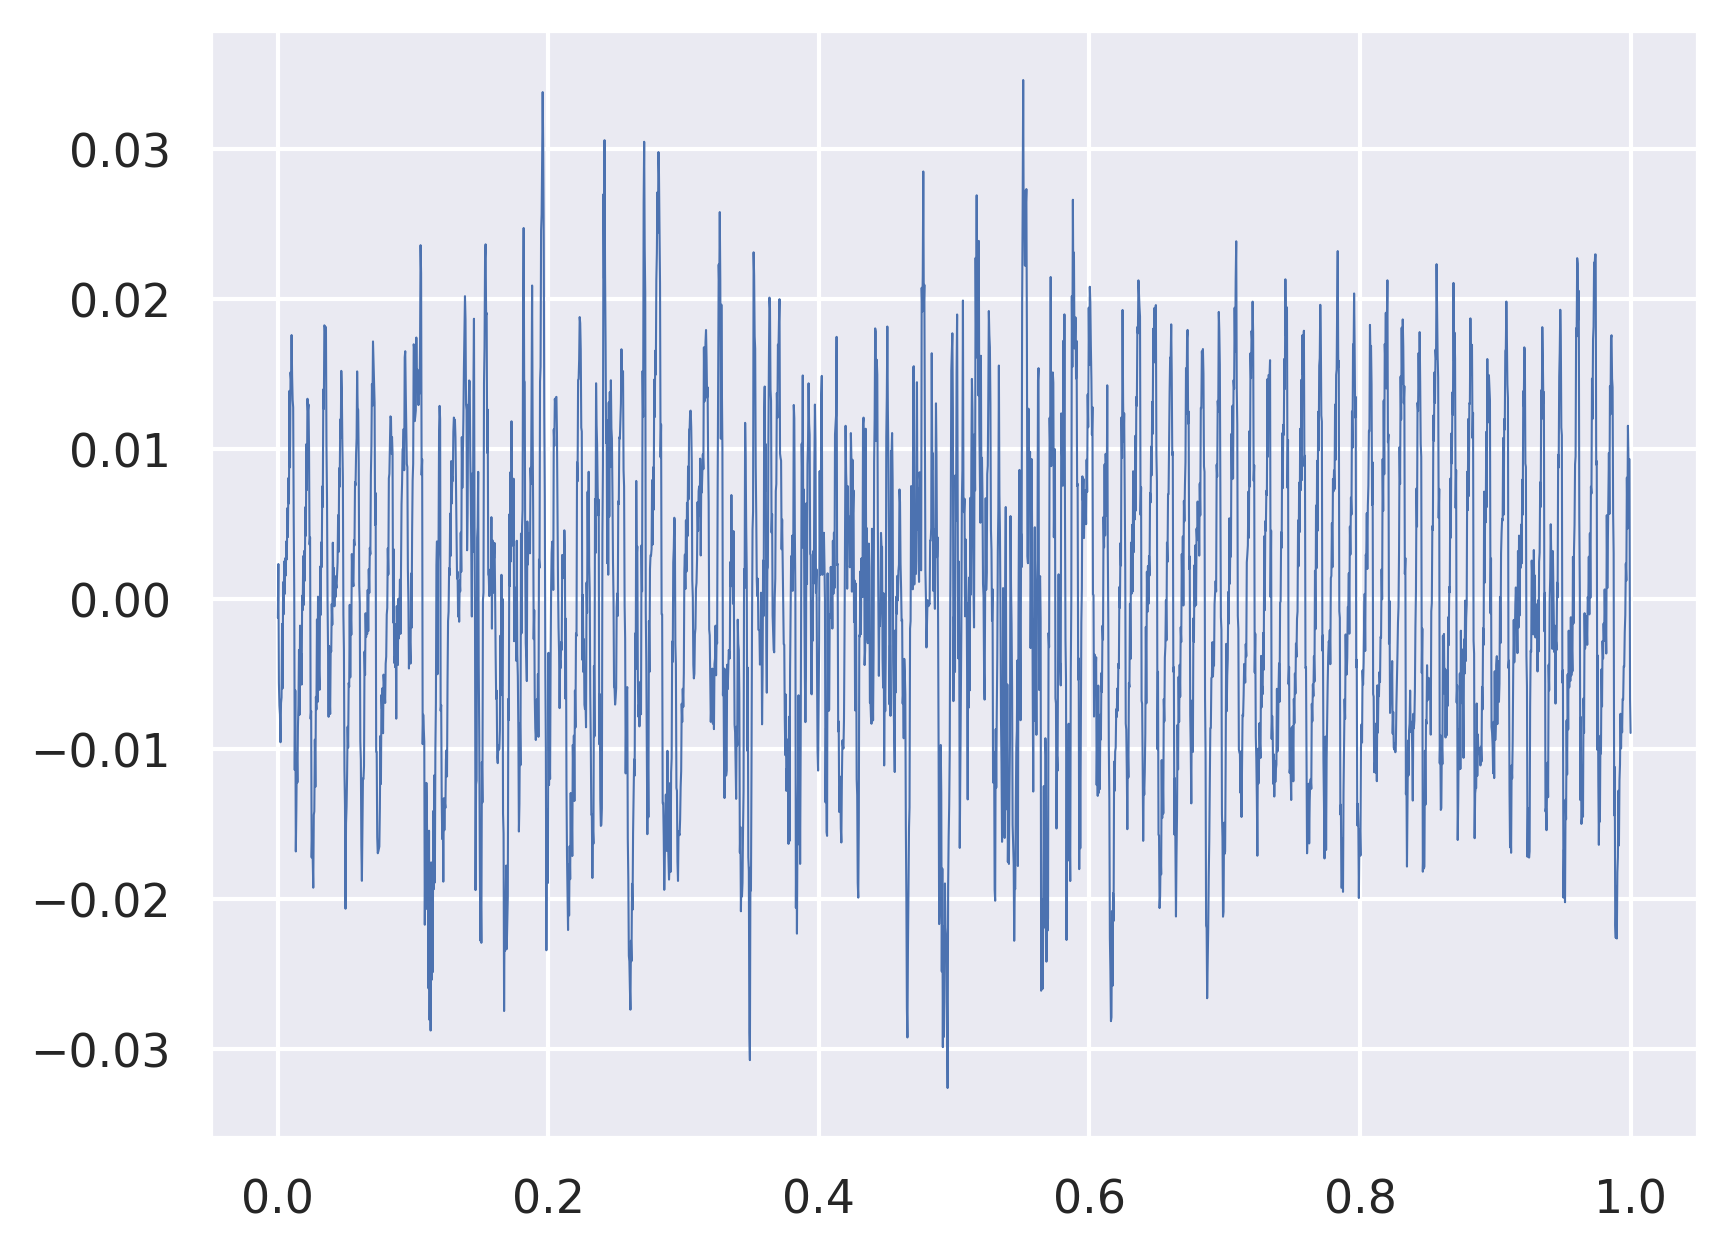

In [40]:
cfs = coeffs.copy()

for i in range(3, len(cfs)):
        cfs[i] = pywt.threshold(cfs[i], 0.1*np.max(cfs[i]), 'garrote')

red = min_max_scaler.transform(np.array(df['red']).reshape((-1,1)))
recreated = pywt.waverec(cfs, 'sym4')
recreated = min_max_scaler.transform(recreated.reshape((-1,1)))
plt.plot(np.linspace(0, 1., num=len(red)), red-recreated, lw=0.5)
noisy = red-recreated

In [41]:
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

filtered = butter_lowpass_filter(noisy, cutoff, fs, nyq)
plt.plot(np.linspace(0, 1., num=len(filtered)), filtered, lw=0.5)

ValueError: The length of the input vector x must be greater than padlen, which is 48.